#### TWB Comparison PRISM, ERA5 and CONUS404
1 (i, j) @Yuma comparison
PRISM TWB is calculated from daily PRISM temperature and dewpoint, and pressure from ERA5
2 To explore the effect of spatial scale on the comparison of CONSUS404, ERA5 and PRISM. ( take an area average over a 50km box, then a 100km box, then a 200km box, then a 500km box)

#### 1) extract hourly timeseries of ERA5 and WRFCONUS at Yuma AZ
 - 1.1) get lat-lon of Yuma, AZ usging geolocator
 - 1.2) get index (i, j) of Yuma in WRF CONUS404 (unstructured RCM grid)
 - 1.3) extract hourly data time series from unstructured grid WRF CONUS404
 - 1.4) extract hourly data time series of ERA5 over Yuma, AZ (structual grid) 
 
#### 2) mash plot days > 90 percentile.
#### 3) output the date of  > 90 percentile
#### 4) Line plot of the 50,75, 90, 95, 99, 99.9 TWB percentiles for each dataset 
  - 4b) average diurnal cycle for CONUS404 and ERA5 in Aug

#### 5) Compute observation (PRISM) 
 - 5.1) read PRISM T2, Tmean (i,j) at Yuma
 - 5.2.1) extract TD daily data time series from unstructured grid PRISM
 - 5.2.2) extract T2 daily data time series from unstructured grid PRISM
 - 5.2.3) get pressure i,j from ERA5
 - 5.3) calculate observational daily TWB
  
#### 6)Comarison ERA5, WRFCONUS404 vs. PRISM 
 - 6.1) resample ERA5, WRFCONUS404 hourly data to daily data
 - 6.2) timeseries plots of annual number of days > 90th percentile
 - 6.3)  timeseries plots of annual max TWB.  
 - 6.4)  Line plot of the 50,75, 90, 95, 99, 99.9 TWB daily mean percentiles of each dataset

In [1]:
import sys
import os.path
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import datetime
import geopy
import scipy

from scipy.interpolate import griddata
from geopy.geocoders import Nominatim
from metpy.calc import wet_bulb_temperature
from metpy.units import units

# inorder to import my pathon module, add
# $PYTHONPATH for jupyter for module
sys.path.append("/glade/u/home/mingge/PYTHON")
import dod_func 
from importlib import reload
reload(dod_func)
from dod_func import find_indices
from dod_func import plot_mesh_p2
from dod_func import cal_qs
from dod_func import cal_p90_df
from dod_func import mask_perc
from dod_func import extract_box_prism

In [2]:
def plot_xy2(q_1d, p_2d, method, x_title):
    fig, ax = plt.subplots()

    ax.plot(q_1d, p_2d[0],label = "CONUS404", linestyle="-", linewidth=2.0)
    ax.plot(q_1d, p_2d[1],label = "ERA5", linestyle="-", linewidth=2.0)

    #plt.title('My title')
    plt.xlabel(x_title)
    plt.ylabel('TWB(C) ' + method)
    plt.legend()
    plt.show()
    
def plot_xy3(q_1d, p_2d, x_title, p_title):
    fig, ax = plt.subplots()

    ax.plot(q_1d, p_2d[0],label = "CONUS404", linestyle="-", linewidth=2.0)
    ax.plot(q_1d, p_2d[1],label = "ERA5",     linestyle="-", linewidth=2.0)
    ax.plot(q_1d, p_2d[2],label = "PRISM",    linestyle="-", linewidth=2.0)
 
    plt.ylim([10, 27])
    plt.title(p_title)
    plt.xlabel(x_title)
    plt.ylabel('TWB(C) daily')
    plt.legend()
    plt.show()


#### setup

In [3]:
dir_c = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/TWB/'
dir_e = '/glade/campaign/mmm/c3we/wetbulb/'
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/'

year_s = 1980
year_e = 2020
 
n_year = year_e - year_s + 1
n_366 = 366

StartDay = datetime.datetime(year_s, 1, 1, 0)
StopDay  = datetime.datetime(year_e, 12, 31, 23)
TimeHH   = pd.date_range(StartDay, end=StopDay, freq='1h')
 
print('n_hours:', len(TimeHH), ' between', StartDay, 'and', StopDay)

n_hours: 359424  between 1980-01-01 00:00:00 and 2020-12-31 23:00:00


#### 1.1) get lat-lon of Yuma, AZ usging geolocator

In [4]:
# Create a geolocator object using the Openstreet Nominatim API. 
# It’s a good idea to increase the default timeout setting from 1s to 10s 
# so that you don’t get a TimedOut exception. 
# You’ll also need to enter a name (any name) for the ‘user_agent’ attribute.
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
#loc = geolocator.geocode('Yuma' + ','+ 'US')
loc = geolocator.geocode('Yuma, US')
lat_pt = loc.latitude
lon_pt = loc.longitude

points = ([[lon_pt, lat_pt]])

#points = np.array([lon_pt, lat_pt]).transpose() 
print(points)

[[-114.47603157249804, 32.665135]]


#### 1.2) get index (i, j) of Yuma in WRF CONUS404 (unstructured RCM grid)

In [5]:
# a test
flnm_c =  dir_c + 'TWB_202012_CONUS404.nc' 
print(flnm_c)

with  xr.open_dataset(flnm_c) as ds:
    Lat = ds.lat.to_numpy()
    Lon = ds.lon.to_numpy()  
     
    ind = find_indices(points, Lon, Lat, tree=None)[0]
    print('model Lon-Lat', Lon[ind[1],ind[0]], Lat[ind[1],ind[0]], 'vs actual lon_lat', points)
    

/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/TWB/TWB_202012_CONUS404.nc


/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
module 'cfgrib.messages' has no attribute 'DEFAULT_INDEXPATH'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


model Lon-Lat -114.47633 32.65857 vs actual lon_lat [[-114.47603157249804, 32.665135]]


#### 1.3) extract hourly data time series from  unstructured grid WRF CONUS404 

In [6]:
## for [point, 0.5, 1, 2, 4) degree boxes
ij_s   = ['pt', 'half_deg', '1deg', '2deg', '4deg']
n_box  = len(ij_s)
ij_wrf = [0, 6, 12, 24, 48]

for nb in range(n_box):
    if ij_s[nb] == 0:
        flnm_ow = dir_o + 'twb_yuma_conus404_hourly_pt.csv'
    else:    
        flnm_ow = dir_o + 'twb_yuma_conus404_hourly_' + ij_s[nb] + '.csv'
    
    if os.path.exists(flnm_ow): 
        print(flnm_ow, 'exist')
    else:       
        for year in range(year_s, year_e + 1):
            print(year)
            for month in range(1,12+1):
                flnm = dir_c + 'TWB_' + str(year) + str(month).zfill(2) + '_CONUS404.nc' 
        
                with xr.open_dataset(flnm) as ds:
                    if ij_wrf[nb] == 0:
                        var = ds['TWB'][:, ind[1],ind[0]]
                    else:
                        var = ds['TWB'][:,ind[1]-ij_wrf[nb]:ind[1]+ij_wrf[nb], ind[0]-ij_wrf[nb]:ind[0]+ij_wrf[nb]].mean(dim=['yc', 'xc'])
                        
                if year == year_s and month == 1:
                    var_new = var
                else:
                    var_new = np.append(var_new, var, axis=0)
            
        df = pd.DataFrame(var_new, index = TimeHH,  columns = ['Yuma'])
         
        print(flnm_ow)
        df.to_csv(flnm_ow)      

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_pt.csv exist
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_half_deg.csv exist
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_1deg.csv exist
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_2deg.csv exist
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_4deg.csv exist


#### 1.4) extract hourly data time series of ERA5 over Yuma, AZ (structual grid) 

In [7]:
## for [0, 0.5, 1, 2, 4) degree boxes
lon_pt_era5=lon_pt+360
ij_era5_dict = {'pt':0, 
                'half_deg':[lat_pt-0.25, lat_pt+0.25, lon_pt_era5-0.25, lon_pt_era5+0.25],
                    '1deg':[lat_pt-0.5,  lat_pt+0.5,  lon_pt_era5-0.5,  lon_pt_era5+0.5], 
                    '2deg':[lat_pt-1,    lat_pt+1,    lon_pt_era5-1,     lon_pt_era5+1], 
                    '4deg':[lat_pt-2,    lat_pt+2,    lon_pt_era5-2,     lon_pt_era5+2]}
n_box  = len(ij_era5_dict)

for key in ij_era5_dict:
    flnm_oe = dir_o + 'twb_yuma_era5_hourly_' + key + '.csv'
     
    if os.path.exists(flnm_oe): 
        print(flnm_oe, 'exist')          
    else:       
        for year in range(year_s, year_e + 1):
            for month in range(1,12+1):
                flnm_e = dir_e + 'TWB_' + str(year) + str(month).zfill(2) + '.nc' 
                with xr.open_dataset(flnm_e) as ds:
                    if key == 'pt':
                        var = ds['TWB'].sel(latitude=lat_pt, longitude=lon_pt+360, 
                                             method="nearest").values
                    else:
                        var = ds['TWB'].sel(latitude=slice(ij_era5_dict[key][1],ij_era5_dict[key][0]),
                                             longitude=slice(ij_era5_dict[key][2],ij_era5_dict[key][3])) \
                                             .mean(dim=['latitude', 'longitude']) 
                if year == year_s and month == 1:
                    var_new = var   
                else:
                    var_new = np.append(var_new, var, axis=0)
            
        df = pd.DataFrame(var_new, index = TimeHH,  columns = ['Yuma'])
 
        print(flnm_oe)
        df.to_csv(flnm_oe)  
        print('SUCCEED')  

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_pt.csv exist
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_half_deg.csv exist
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_1deg.csv exist
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_2deg.csv exist
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_4deg.csv exist


#### 2) Calculate and plot days > 90 percentile.

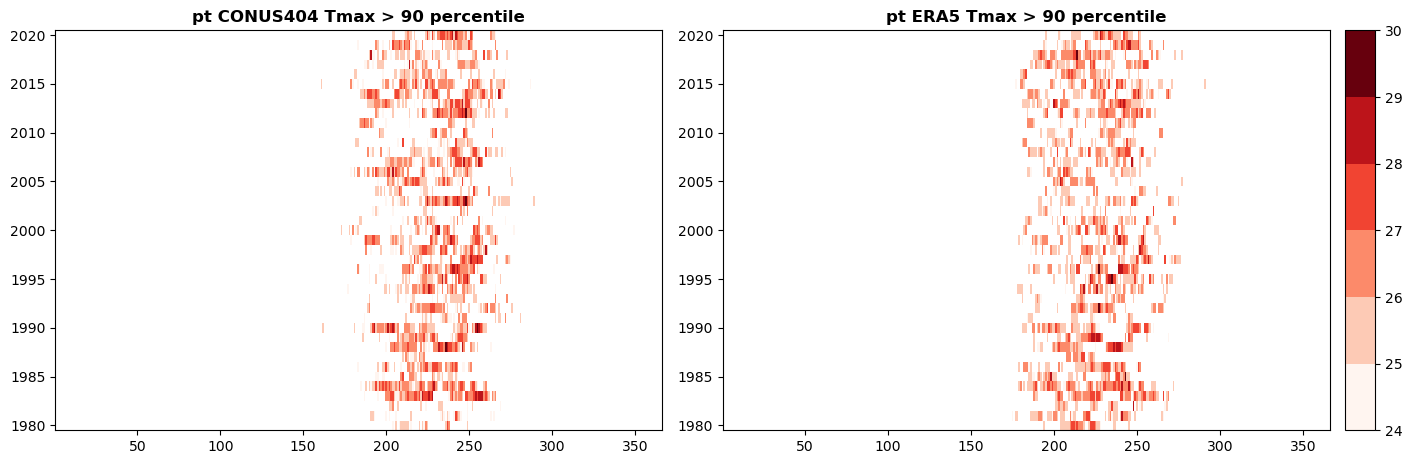

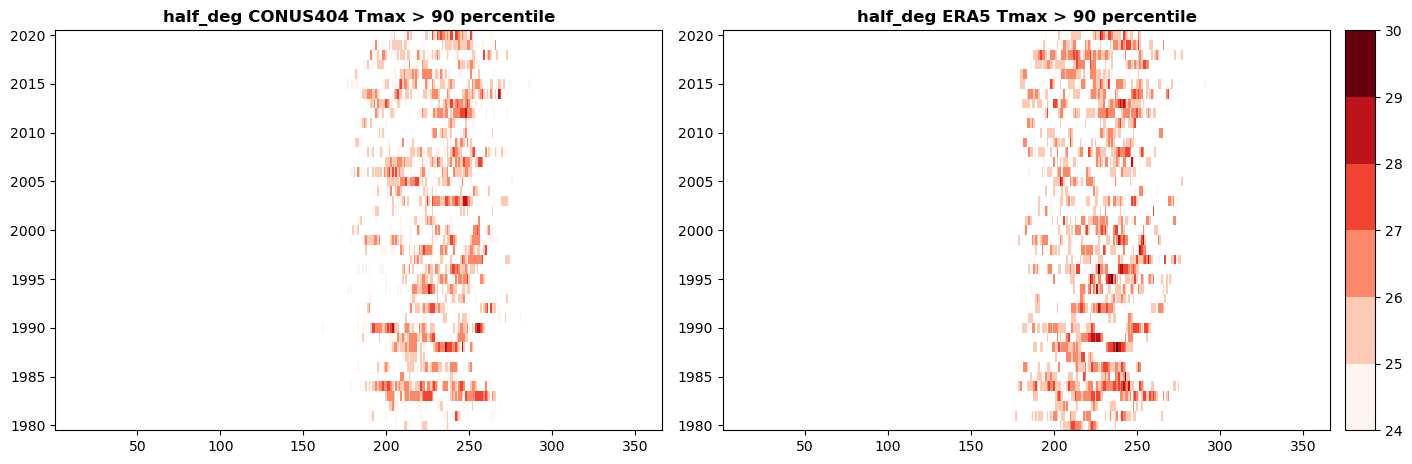

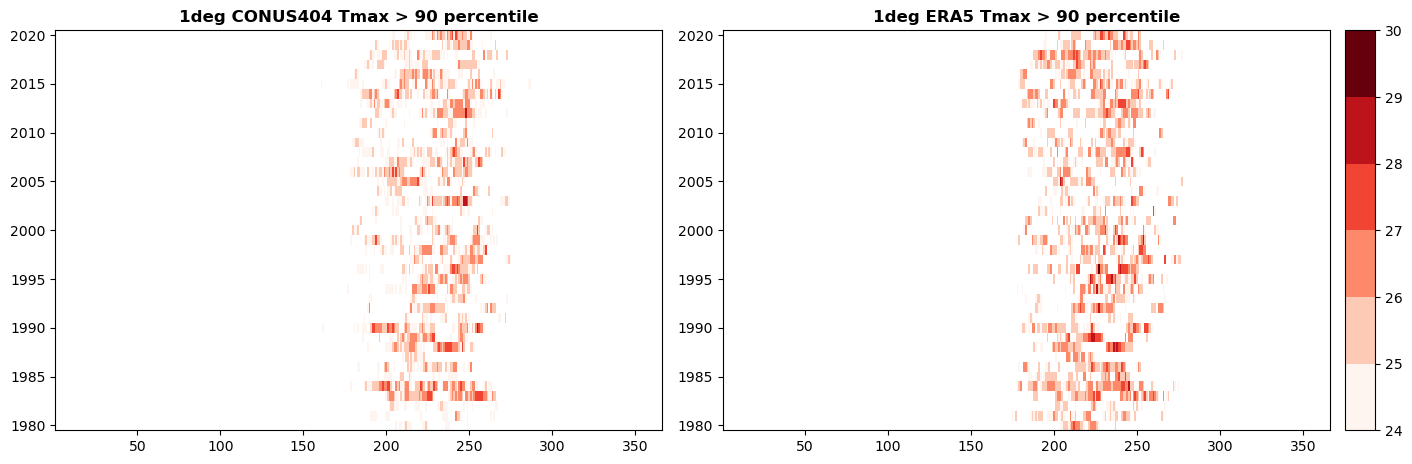

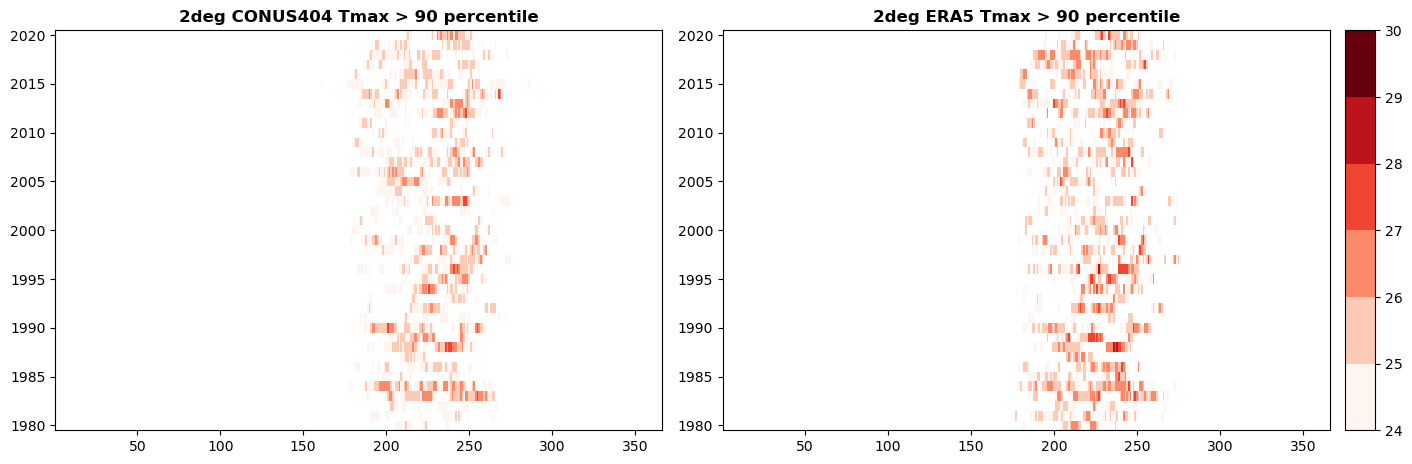

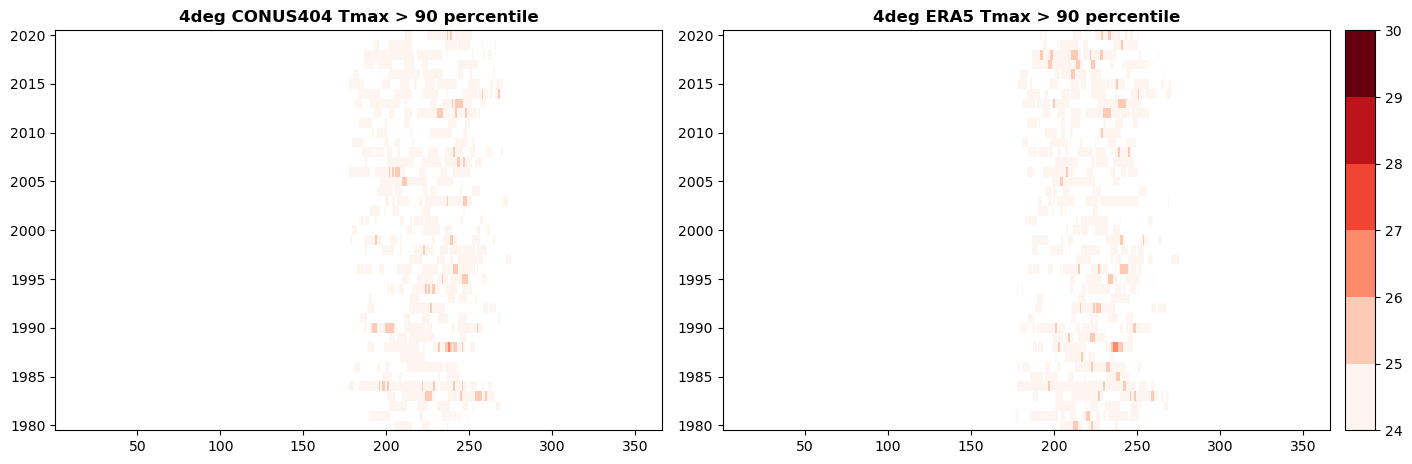

In [8]:
flnm_wrf_1d  = [None] * n_box
flnm_era5_1d = [None] * n_box

for nb in range(n_box):
    if ij_s[nb] == 0:
        flnm_wrf_1d[nb]  = dir_o + 'twb_yuma_conus404_hourly_pt.csv'
        flnm_era5_1d[nb] = dir_o + 'twb_yuma_era5_hourly_pt.csv'
    else:    
        flnm_wrf_1d[nb]  = dir_o + 'twb_yuma_conus404_hourly_' + ij_s[nb] + '.csv'
        flnm_era5_1d[nb] = dir_o + 'twb_yuma_era5_hourly_' + ij_s[nb] + '.csv'
 
    flnm_1d = [flnm_wrf_1d[nb], flnm_era5_1d[nb]]
    title_1d = [ij_s[nb] + ' CONUS404', ij_s[nb] + ' ERA5']

    plot_mesh_p2(flnm_1d, title_1d, year_s, year_e)

#### 3) output the date of > 90 percentile

In [9]:
flnm_wrf_1d  = [None] * n_box
flnm_era5_1d = [None] * n_box

flnm_wrf_o  =  [None] * n_box
flnm_era5_o =  [None] * n_box

col_name_wrf  =  [None] * n_box
col_name_era5 =  [None] * n_box

# create file names and column names 
for nb in range(n_box):
    if ij_s[nb] == 0:
        flnm_wrf_1d[nb]   = dir_o + 'twb_yuma_conus404_hourly_pt.csv'
        flnm_era5_1d[nb]  = dir_o + 'twb_yuma_era5_hourly_pt.csv'
        flnm_wrf_o[nb]    = dir_o + 'twb_yuma_conus404_p90_pt.csv'
        flnm_era5_o[nb]   = dir_o + 'twb_yuma_era5_p90_pt.csv'
        col_name_wrf[nb]  = 'WRF PT'
        col_name_era5[nb] = 'ERA5 PT'
    else:    
        flnm_wrf_1d[nb]  = dir_o + 'twb_yuma_conus404_hourly_' + ij_s[nb] + '.csv'
        flnm_era5_1d[nb] = dir_o + 'twb_yuma_era5_hourly_' + ij_s[nb] + '.csv'
        flnm_wrf_o[nb]   = dir_o + 'twb_yuma_conus404_p90_' + ij_s[nb] + '.csv'
        flnm_era5_o[nb]  = dir_o + 'twb_yuma_era5_p90_' + ij_s[nb] + '.csv'
        col_name_wrf[nb]  = 'WRF ' + ij_s[nb]
        col_name_era5[nb] = 'ERA5 ' + ij_s[nb]

flnm_i_1d = flnm_wrf_1d + flnm_era5_1d   
flnm_o_1d = flnm_wrf_o  + flnm_era5_o

colum_1d = col_name_wrf + col_name_era5

ct = 0
for flnm in flnm_i_1d:
    p90_tmax, df_dmax = cal_p90_df(flnm) 
    
    df = pd.read_csv(flnm, index_col = 0)
    
    # Create DatetimeIndex by DataFrame.set_index
    # in order to use 'resample'
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H')
        
    # resample hourly data to daily data
    df_dmax = df.resample('D').max()
 
    df = df_dmax[df_dmax['Yuma'] > p90_tmax.values[0]]
    df.to_csv(flnm_o_1d[ct])

    print(flnm_o_1d[ct], p90_tmax.values[0] )
    ct = ct + 1
    
print('SUCCEED')      

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_p90_pt.csv 297.85498
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_p90_half_deg.csv 297.462705
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_p90_1deg.csv 297.182495
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_p90_2deg.csv 296.84497
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_p90_4deg.csv 295.69045
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_p90_pt.csv 24.866211
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_p90_half_deg.csv 24.742424
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_p90_1deg.csv 24.564924
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_p90_2deg.csv 24.260163499999997
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_p90_4deg.csv 22.7672275
SUCCEED


 #### 4) Line plot of the 50,75, 90, 95, 99, 99.9 TWB(max)  

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_pt.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_half_deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_1deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_2deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_4deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_pt.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_half_deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_1deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_2deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_4deg.csv


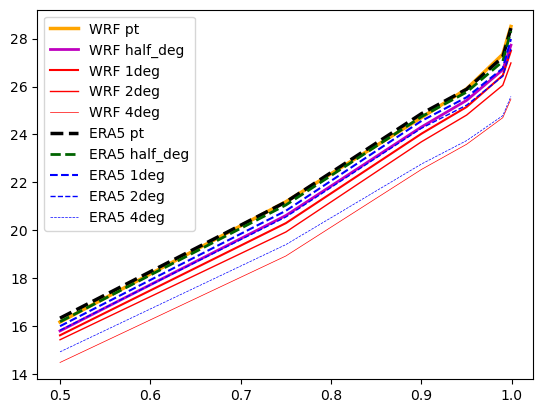

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_pt.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_half_deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_1deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_2deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_4deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_pt.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_half_deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_1deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_2deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_4deg.csv


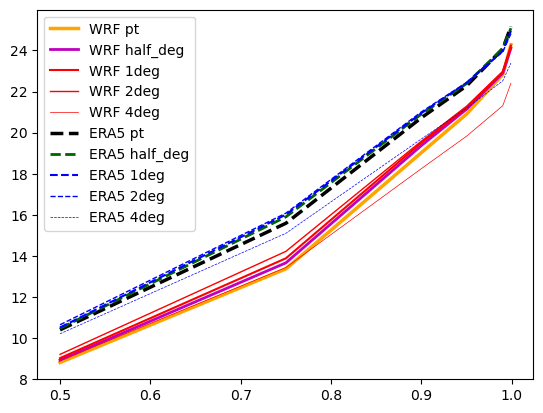

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_pt.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_half_deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_1deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_2deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_4deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_pt.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_half_deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_1deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_2deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_4deg.csv


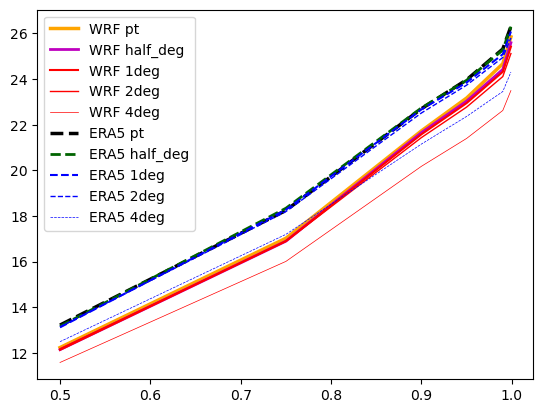

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_pt.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_half_deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_1deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_2deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly_4deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_pt.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_half_deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_1deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_2deg.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era5_hourly_4deg.csv


In [ ]:
q_1d = [.50, .75, .90, .95, .99, .999]
n_q = len(q_1d)
p_2d = np.zeros((n_q, len(flnm_i_1d)))

method_1d = ['max', 'min', 'mean', 'mean_from_max_min']
 
style_l = ['solid', 'solid','solid','solid','solid','dashed','dashed','dashed','dashed','dashed']
lw_l    = [2.5, 2, 1.5, 1, 0.5, 2.5, 2, 1.5, 1, 0.5 ]
color_l = ['orange','m','r','r','r','black','darkgreen','b','b','b']

for method in method_1d:
    ct = 0
    for flnm in flnm_i_1d:
        p_2d[:,ct] = np.array(cal_qs(flnm, q_1d, method))
        # K->C
        if "conus" in flnm:
            p_2d[:, ct] = p_2d[:, ct] - 273.15
        else:
            p_2d[:,ct] = p_2d[:,ct] 
            
        plt.plot(q_1d, p_2d[:, ct], label =colum_1d[ct] , linestyle= style_l[ct], 
                 color = color_l[ct],linewidth = lw_l[ct])     
        
        ct = ct + 1
        
    plt.legend()
    plt.show()

#### 4b) average diurnal cycle for CONUS404 and ERA5 in Aug
(hourly data)? Maybe we can define the average using all values for August for all years.

In [ ]:
ct = 0
for flnm in flnm_i_1d:
    df = pd.read_csv(flnm, index_col = 0)
    print(flnm)
    
    # Create DatetimeIndex by DataFrame.set_index
    # in order to use 'resample'
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H')
    df['hour'] = df.index.hour    
    df['month'] =  df.index.month
     
    ind_m = df.groupby('month').get_group((8)).index
    df_m =  df.loc[ind_m]
    df_h =  df_m.groupby('hour').mean()
    
    if "conus" in flnm:
        Tdiurnal= df_h['Yuma'] - 273.15
    else:
        Tdiurnal= df_h['Yuma']
        
    plt.plot(range(1,25), Tdiurnal, label =colum_1d[ct] , linestyle= style_l[ct], 
                 color = color_l[ct],linewidth = lw_l[ct])  
    ct = ct +1
    
plt.legend()
plt.show()

#### 5 to compare with an observation.
Observational TWB is calculated from PRISM (TD, T) and ERA5 (SLP)
- 5.1) read PRISM (i,j) at Yuma

In [ ]:
dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/'
dir_td = dir_prism + 'TDmean/'
dir_t2 = dir_prism + 'T2M/'

year_s = 1981
StartDay = datetime.datetime(year_s, 1, 1, 0)
StopDay  = datetime.datetime(year_e, 12, 31, 23)
 
TimeDD   = pd.date_range(StartDay, end=StopDay, freq='1d')

In [ ]:
flnm_td =  dir_td + 'PRISM_daily_tdmean_1990.nc' 
 
with  xr.open_dataset(flnm_td) as ds:
    Lat = ds.lat.to_numpy()
    Lon = ds.lon.to_numpy()   
    ind = find_indices(points, Lon, Lat, tree=None)[0]
    print('model Lon-Lat', Lon[ind[1],ind[0]], Lat[ind[1],ind[0]], 'vs actual lon_lat', points)

- 5.2.1)  extract T2 and TD daily data time series from unstructured grid PRISM

In [ ]:
#### PRISM data 4KM
ij_unstr_dict = {     'pt':0, 
                'half_deg':6,
                    '1deg':12, 
                    '2deg':24, 
                    '4deg':48}

extract_box_prism('t', dir_t2, dir_o, ij_unstr_dict, year_s, year_e, ind[1], ind[0])
extract_box_prism('td', dir_td, dir_o, ij_unstr_dict, year_s, year_e, ind[1], ind[0])

 - 5.2.2) get pressure i,j from ERA5

 - 5.3) calculate observational daily TWB
 from PRISM T, TD, and ERA5: sfc

In [ ]:
year3_s = 1981
year3_e = 2018

ind_s = str(year3_s) + '-01-01'
ind_e = str(year3_e) + '-12-31'

for key in ij_unstr_dict:
    print(key)
    flnm_t2 = dir_o + 't_yuma_prism_daily_' + key + '.csv' 
    flnm_td = dir_o + 'td_yuma_prism_daily_' + key + '.csv'
    flnm_sfc = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/sfc_yuma_era5_daily_' + key + '.csv'
    flnm_op = dir_o + 'twb_yuma_op_daily_' + key + '.csv'
    
    if os.path.exists(flnm_op): 
        print(flnm_op, 'exist')
        twb_df = pd.read_csv(flnm_op, index_col = 0)    
    else:
        if not os.path.exists(flnm_t2): 
            print(flnm_t2, 'not exist') 
        else:
            print(flnm_t2, 'exist')
        
        if not os.path.exists(flnm_td): 
            print(flnm_td, 'not exist') 
        else:
            print(flnm_td, 'exist') 
        
        if not os.path.exists(flnm_sfc): 
            print(flnm_sfc, 'not exist') 
        else:
            print(flnm_sfc, 'exist') 
        
        df = pd.read_csv(flnm_t2, index_col = 0)
        # Create DatetimeIndex by DataFrame.set_index
        # in order to use 'resample'
        df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
        t2_df = df.loc[ind_s:ind_e]

        df = pd.read_csv(flnm_td, index_col = 0)
        # Create DatetimeIndex by DataFrame.set_index
        # in order to use 'resample'
        df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
        td_df = df.loc[ind_s:ind_e]

        df = pd.read_csv(flnm_sfc, index_col = 0)
        # Create DatetimeIndex by DataFrame.set_index
        # in order to use 'resample'
        df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
        sfc_df = df.loc[ind_s:ind_e]
        
        # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wet_bulb_temperature.html
        twb_obs = wet_bulb_temperature(sfc_df.values * units.hPa, t2_df.values * units.degC, td_df.values * units.degC)
        twb_df = pd.DataFrame(twb_obs, columns=['Yuma'])  
        twb_df.index = sfc_df.index
        print(flnm_op)
        twb_df.to_csv(flnm_op)  


#### 6) Comarison ERA5, WRFCONUS404 vs. PRISM   

 - 6.1) resample ERA5, WRFCONUS404 hourly data to daily data

In [ ]:
is_from_MaxMin = True

for key in ij_unstr_dict:
    for model in ['conus404','era5']:
        flnm_h = dir_o + 'twb_yuma_' + model +'_hourly_' + key + '.csv'
        if is_from_MaxMin == True:
            flnm_d = dir_o + 'twb_yuma_' + model + '_daily_' + key + '_from_MaxMin.csv'
        else:
            flnm_d = dir_o + 'twb_yuma_' + model + '_daily_' + key + '.csv'
        #print(flnm_h)
        #print(flnm_d)
        if os.path.exists(flnm_d): 
            print(flnm_d, 'exist')
        else:
            df = pd.read_csv(flnm_h, index_col = 0)
            # Create DatetimeIndex by DataFrame.set_index
            # in order to use 'resample'
            df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H')
        
            # resample hourly data to daily data
            if is_from_MaxMin == True:
                 df_0 = (df.resample('D').max().loc[ind_s:ind_e] +
                         df.resample('D').min().loc[ind_s:ind_e])*0.5
            else:
                 df_0 = df.resample('D').mean().loc[ind_s:ind_e] 
    
            if "conus" in flnm_h:
                df_0['Yuma'] = df_0['Yuma'] - 273.15
    
            print(flnm_d)
            df_0.to_csv(flnm_d) 


- 5.4.2) timeseries plots of annual number of days > 90th percentile

In [ ]:
title_1d = ['CONUS404', 'ERA5', 'PRISM']

for key in ij_unstr_dict:
    flnm_1d = [dir_o + 'twb_yuma_conus404_daily_' + key + '_from_MaxMin.csv',  
           dir_o + 'twb_yuma_era5_daily_' + key + '_from_MaxMin.csv', 
           dir_o + 'twb_yuma_op_daily_' + key + '.csv']

    p_2d = np.zeros((len(flnm_1d), year3_e - year3_s + 1))

    nn = 0
    for flnm in flnm_1d:
        print(flnm)
        df = pd.read_csv(flnm, index_col = 0)
        # Create DatetimeIndex by DataFrame.set_index
        # in order to use 'resample'
        df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
                 
        # calculate quantile over requested axis
        p90_tmax = df.quantile(.9, axis = 0)
    
        # [0]: pandas Series.values returns Series as ndarray or ndarray-like
        itt = df.index[df['Yuma'] > p90_tmax.values[0]]
        #df_p = df.loc[itt]
        df_p = df.loc[itt].resample('Y').count()
        p_2d[nn] = df_p['Yuma']
     
        df_p.index = range(year3_s, year3_e+1)
    
        if nn == 0:
            df_p.rename(columns = {'Yuma':title_1d[nn]}, inplace = True)  
            twb_df = df_p.copy() 
        else:
            twb_df[title_1d[nn]] = df_p['Yuma']
    
        nn = nn + 1

    twb_df.plot(figsize=(8,4), xlim=(year3_s, year3_e), ylabel='day'
            , title = key + ' annual number of days > 90th percentile'); 

 -  5.4.3) annual max TWB   

In [ ]:
for key in ij_unstr_dict:
    flnm_1d = [dir_o + 'twb_yuma_conus404_daily_' + key + '_from_MaxMin.csv',  
               dir_o + 'twb_yuma_era5_daily_' + key + '_from_MaxMin.csv', 
               dir_o + 'twb_yuma_op_daily_' + key + '.csv']

    p_2d = np.zeros((len(flnm_1d), year3_e - year3_s + 1))

    nn = 0
    for flnm in flnm_1d:
        print(flnm)
        df = pd.read_csv(flnm, index_col = 0)
        # Create DatetimeIndex by DataFrame.set_index
        # in order to use 'resample'
        df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
                  
        df_p = df.resample('Y').max()
        p_2d[nn] = df_p['Yuma']
     
        df_p.index = range(year3_s, year3_e+1)
    
        if nn == 0:
            df_p.rename(columns = {'Yuma':title_1d[nn]}, inplace = True)  
            twb_df = df_p.copy() 
        else:
            twb_df[title_1d[nn]] = df_p['Yuma']
    
        nn = nn + 1

    twb_df.plot(figsize=(8,4), xlim = (year3_s, year3_e), ylabel='TWB(C)'
               , title=key + ' Annual Maximum TWB');

- 6.4)  Line plot of the 50,75, 90, 95, 99, 99.9 TWB daily mean percentiles of each dataset

In [ ]:
q_1d = [.50, .75, .90, .95, .99, .999]
n_q = len(q_1d)

for key in ij_unstr_dict:
    flnm_1d = [dir_o + 'twb_yuma_conus404_daily_' + key + '_from_MaxMin.csv',  
               dir_o + 'twb_yuma_era5_daily_' + key + '_from_MaxMin.csv', 
               dir_o + 'twb_yuma_op_daily_' + key + '.csv']
    n_f = len(flnm_1d)
    p_2d = np.zeros((n_f, n_q))

    ct = 0      
    for flnm in flnm_1d:
        p_2d[ct] = cal_qs(flnm, q_1d, method)
        ct = ct + 1
    
    plot_xy3(q_1d, p_2d,  'percentile', key)   